# DIT NLP lesson 2024

## CNNs on text

In order to run this notebook, I had to pay for Colab computing credits and activate an A100 runtime

In [ ]:
# To check what is the amount of memory available

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
import glob
import numpy as np
import os
import os.path
import tarfile

from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence   # necessary for padding
from keras.models import Sequential        # Base Keras NN model
from keras.layers import Conv1D, GlobalMaxPooling1D # Convolution layer and pooling
from keras.layers import Dense, Dropout, Activation # The objects for each layer

from nltk.tokenize import TreebankWordTokenizer
from random import shuffle
from urllib import request


For this exercise, we first download Stanford's [Large Movie Review Dataset](https://ai.stanford.edu/%7eamaas/data/sentiment/aclImdb_v1.tar.gz). More information on the corpus at [Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/%7eamaas/papers/wvSent_acl2011.pdf)

In [ ]:
PATH_TO_CORPUS = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
CORPUS_FILE_NAME = "aclImdb_v1.tar.gz"

PATH_TO_GOOGLENEWS_VECTORS ="https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz?dl=1"
GOOGLE_VECTORS = "GoogleNews-vectors-negative300.bin.gz"

CORPUS_PATH = "aclImdb/train"

def download_file(url_to_file, path_to_file):
  if os.path.isfile(path_to_file):
    print("A local copy of the file exists already:", path_to_file, "\nDoing nothing")
  else:
    request.urlretrieve(url_to_file, path_to_file)

In [ ]:
# Downloading the embeddings

download_file(PATH_TO_GOOGLENEWS_VECTORS, GOOGLE_VECTORS)

In [ ]:
# Downloading and untaring the corpus

download_file(PATH_TO_CORPUS, CORPUS_FILE_NAME)
with tarfile.open(CORPUS_FILE_NAME) as f:
  f.extractall(path=".")

In [ ]:
# A method to read and shuffle all instances (one per file).
# Positive (negative) instances are in the pos (neg) folder

def pre_process_data(filepath):
    """
    This is dependent on your training data source but we will
    try to generalize it as best as possible.
    """
    positive_path = os.path.join(filepath, 'pos')
    negative_path = os.path.join(filepath, 'neg')
    pos_label = 1
    neg_label = 0
    dataset = []

    # glob.glob returns a list of path names that match pathname
    for filename in glob.glob(os.path.join(positive_path, '*.txt')):
        with open(filename, 'r') as f:
            dataset.append((pos_label, f.read()))

    for filename in glob.glob(os.path.join(negative_path, '*.txt')):
        with open(filename, 'r') as f:
            dataset.append((neg_label, f.read()))
    shuffle(dataset)
    return dataset

In [ ]:
# Preprocessing the data
dataset = pre_process_data(CORPUS_PATH)
dataset[0]

In [ ]:
# Loading the word2vec embeddings

word_vectors = KeyedVectors.load_word2vec_format(GOOGLE_VECTORS,
    binary=True, limit=400000)

# If you want to try to run with less memory, an alternative is to reduce the
# vocabulary
# (e.g., to 200000 or to 100000)
# word_vectors = KeyedVectors.load_word2vec_format(GOOGLE_VECTORS,
#     binary=True, limit=400000)

In [ ]:
# Method to tokenise and vectorise all the training data

def tokenize_and_vectorize(dataset):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
#    expected = [] this line appears in the book, but it's not necessary here!
    for sample in dataset:
        tokens = tokenizer.tokenize(sample[1])
        sample_vecs = []
        for token in tokens:
            try:
                sample_vecs.append(word_vectors[token])
            except KeyError:
                pass # No matching token in the Google w2v vocab
        vectorized_data.append(sample_vecs)

    return vectorized_data

In [ ]:
# Method to get the target labels
def collect_expected(dataset):
    """ Peel off the target values from the dataset """
    expected = []
    for sample in dataset:
        expected.append(sample[0])
    return expected

In [ ]:
# Vectorising the dataset and extracting the gold standard
vectorized_data = tokenize_and_vectorize(dataset)
expected = collect_expected(dataset)

In [ ]:
# Creating training and validation partitions


split_point = int(len(vectorized_data)*.8)

# Original alternative
x_train = vectorized_data[:split_point] # there's a typo in this line, if copying from the book
y_train = expected[:split_point]
x_test = vectorized_data[split_point:]
y_test = expected[split_point:]

# If you want to try to run with less memory, an alternative is to reduce the
# amount of training/developemt data
# split_point_tr = int(len(vectorized_data)*.5)
# x_train = vectorized_data[:split_point_tr] # I am using less training data
# y_train = expected[:split_point_tr]
# x_test = vectorized_data[split_point:]
# y_test = expected[split_point:]

In [ ]:
# If you want to try to run with less memory, an alternative is to drop the
# files (not so effective)

# import shutil
# vectorized_data = 0
# shutil.rmtree(CORPUS_PATH)
# os.remove(CORPUS_FILE_NAME)
# os.remove(GOOGLE_VECTORS)


In [ ]:
# Network parameters

maxlen = 400          # maximum length of the text (why?)
batch_size = 32       # number of samples before backpropagating
embedding_dims = 300  # Same as Google's
filters = 250         # (!)
kernel_size = 3       # remember: filter=kernel (we have a scalar this time)
hidden_dims = 250     # number of neurons in the final layer
epochs = 2            # number of training epochs

# If you want to try to run with less memory, an alternative is to reduce
# the maximum length of the input and the size of the network
# maxlen = 100          # maximum length of the text (why?)
# batch_size = 32       # number of samples before backpropagating
# embedding_dims = 300  # Same as Google's
# filters = 120         # (!)
# kernel_size = 3       # remember: filter=kernel (we have a scalar this time)
# hidden_dims = 150     # number of neurons in the final layer
# epochs = 2            # number of training epochs

**Back to the slides** to see what is "padding" in text

## Padding

In [ ]:
# Method to pad or truncate the input
# (notice that this code is quite verbose)
def pad_trunc(data, maxlen):
    """
    For a given dataset pad with zero vectors or truncate to maxlen
    """
    new_data = []
    # Create a vector of 0s the length of our word vectors
    zero_vector = []
    for _ in range(len(data[0][0])):
        zero_vector.append(0.0)

    for sample in data:
        if len(sample) > maxlen:
            temp = sample[:maxlen]
        elif len(sample) < maxlen:
            temp = sample
            # Append the appropriate number 0 vectors to the list
            additional_elems = maxlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
        else:
            temp = sample
        new_data.append(temp)

    return new_data

In [ ]:
# Padding/truncating the data (if necessary)

x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)

# The shape is [number of samples, sequence length, word vector]
x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)

## Building the network

Adding the convolutional layer

In [ ]:
print('Building model...')
model = Sequential()   # The standard NN model
model.add(Conv1D(      # Adding a convolutional layer
    filters,
    kernel_size,
    padding='valid',   # in this example the output is going to be slightly smaller
    activation='relu',
    strides=1,         # the shift
    input_shape=(maxlen, embedding_dims))
    )
# Formulation: max (0, dot(filter, 3-gram))

In [ ]:
# Adding the max pooling
# Alternatives
# - GlobalMaxPooling1D() (the max for the entire filter's output)
# - MaxPooling1D(n)  (the max for a specific area of n; default n=2)
# - AvgPooling1D(n)

model.add(GlobalMaxPooling1D())

**back to the slides to see what is pooling (and drop out)**

In [ ]:
# Adding dropout (20% of the data will be "cancelled")
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

In [ ]:
# Adding the classification layer
# sigmoid range: [0,1]
model.add(Dense(1))
model.add(Activation('sigmoid'))

**back to the slides**

In [ ]:
# Compiling the CNN
model.compile(loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
        )

In [ ]:
# Fitting (training) the model
model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
    )

This is how much memory one could need:

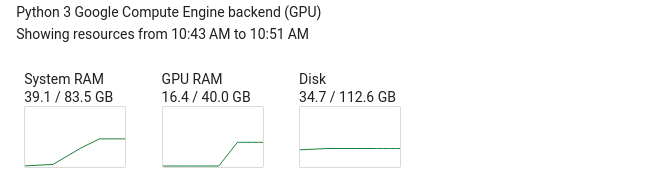

In [ ]:
# Saving the model
model_structure = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_structure)  # saves just the architecture
model.save_weights("cnn.weights.h5")  # saves the weights
# You can run fit many times on the same model (it will continue)

In [ ]:
# (Re)loading the model (not necessary here, but anyway)
from keras.models import model_from_json
with open("cnn_model.json", "r") as json_file:
    json_string = json_file.read()
model = model_from_json(json_string)
model.load_weights('cnn.weights.h5')

In [ ]:
# Predicting a new instance

# Notice we have both positive and negative words here
sample_1 = """I hate that the dismal weather had me down for so long,
when will it break! Ugh, when does happiness return? The sun is
blinding and the puffy clouds are too thin. I can't wait for the weekend."""

# The first value is a "fake" class (this is the expected input)
vec_list = tokenize_and_vectorize([(1, sample_1)])
test_vec_list = pad_trunc(vec_list, maxlen)
test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen,\
        embedding_dims))
model.predict(test_vec)

In [ ]:
# Get the class
(model.predict(test_vec) > 0.5).astype("int32")

**End of the notebook**